# FDRI catchment gauge record vs gridded data at Carreg Wen

The rain gauge record is from Carreg-wen, Pembrokeshire

## Table of contents
[1 Analysis](#1-Analysis)  

In [658]:
import datetime
import numpy as np
import pandas as pd
import polars as pl
import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
sns.set_context('notebook')

# Load data

In [563]:
RAIN_COL = "rain_mm"
START_DATE = datetime.datetime(year=1976, month=1, day=1, hour=9)
END_DATE = datetime.datetime(year=2010, month=1, day=1, hour=9)
OVERLAP_THRESHOLD = 365*3 # three years

## Load CEH-GEAR

In [3]:
ceh_plynlimon = xr.open_dataset('../../../CEH_GEAR/ceh_1km_plynlimonregion_19760101_20101231.nc')
ceh_plynlimon = ceh_plynlimon.rename({'rainfall_amount': RAIN_COL})
ceh_plynlimon

<xarray.Dataset> Size: 810MB
Dimensions:   (time: 12784, y: 44, x: 45)
Coordinates:
  * x         (x) float64 360B 2.76e+05 2.77e+05 2.78e+05 ... 3.19e+05 3.2e+05
  * y         (y) float64 352B 2.58e+05 2.59e+05 2.6e+05 ... 3e+05 3.01e+05
  * time      (time) datetime64[ns] 102kB 1976-01-01 1976-01-02 ... 2010-12-31
Data variables:
    lat       (time, y, x) float64 202MB ...
    lon       (time, y, x) float64 202MB ...
    rain_mm   (time, y, x) float64 202MB ...
    min_dist  (time, y, x) float64 202MB ...
    crs       (time) int16 26kB ...
Attributes: (12/30)
    title:                CEH Gridded Estimates of Areal Rainfall (CEH - GEAR...
    institution:          CEH Wallingford - NERC
    source:               CEH - GEAR: dataset created using Natural Neighbour...
    description:          Daily rainfall 1km-gridded dataset created as part ...
    grid_mapping:         crs
    history:              Created Fri 2014-03-21 11:56:35
    ...                   ...
    version_comment:      The version number of each data file corresponds to...
    comment:              In line with standard UK convention, the rainfall o...
    reference:            Tanguy, M., Prosdocimi, I., Keller, V.D.J., Terry, ...
    licence:              Licensing conditions apply (datalicensing@ceh.ac.uk)
    summary:              The CEH-GEAR dataset contains 1-km grids of daily a...
    id:                   5dc179dc-f692-49ba-9326-a6893a503f6e

## Load HadUK-Grid

In [250]:
haduk_plynlimon = xr.open_mfdataset(['../../../HadUK_Grid/haduk_grid_1km_day/hadukgrid_1km_plynlimonregion_19760101_19920831.nc',\
                 '../../../HadUK_Grid/haduk_grid_1km_day/hadukgrid_1km_plynlimonregion_19920901_20091231.nc'])
haduk_plynlimon = haduk_plynlimon.rename({'rainfall': RAIN_COL, 'projection_x_coordinate': 'x', 'projection_y_coordinate': 'y'})
haduk_plynlimon = haduk_plynlimon.drop_vars(('latitude', 'longitude'))
haduk_plynlimon

<xarray.Dataset> Size: 215MB
Dimensions:                       (time: 12419, y: 44, x: 45, bnds: 2)
Coordinates:
  * time                          (time) datetime64[ns] 99kB 1976-01-01T12:00...
  * y                             (y) float64 352B 2.585e+05 ... 3.015e+05
  * x                             (x) float64 360B 2.765e+05 ... 3.205e+05
Dimensions without coordinates: bnds
Data variables:
    rain_mm                       (time, y, x) float64 197MB dask.array<chunksize=(3044, 22, 23), meta=np.ndarray>
    transverse_mercator           (time) int32 50kB dask.array<chunksize=(6088,), meta=np.ndarray>
    time_bnds                     (time, bnds) datetime64[ns] 199kB dask.array<chunksize=(6088, 2), meta=np.ndarray>
    projection_y_coordinate_bnds  (time, y, bnds) float64 9MB dask.array<chunksize=(6088, 44, 2), meta=np.ndarray>
    projection_x_coordinate_bnds  (time, x, bnds) float64 9MB dask.array<chunksize=(6088, 45, 2), meta=np.ndarray>
Attributes:
    comment:        Daily resolution gridded climate observations
    creation_date:  2024-05-17T13:12:49
    frequency:      day
    institution:    Met Office
    references:     doi: 10.1002/gdj3.78
    short_name:     daily_rainfall
    source:         HadUK-Grid_v1.3.0.0
    title:          Gridded surface climate observations data for the UK
    version:        v20240514
    Conventions:    CF-1.7

## Load Gauge data

In [121]:
plynlimon_metadata = pl.read_csv('../gauge_data/mo_plynlimon_area_metadata.csv')
plynlimon_metadata.head()

ID,SRC_ID,NAME,COUNTRY_CODE,EASTING,NORTHING,HYDROMETRIC_AREA,ELEVATION,GEOG_PATH
i64,i64,str,str,i64,i64,i64,i64,str
421169,9670,"""CWM BIGA""","""GB-GBN""",285900,289100,54,309,"""/BI/UK/GB/WAL/POWN/"""
421192,9671,"""BANC-Y-GROES, GRONWEN""","""GB-GBN""",288400,289200,54,297,"""/BI/UK/GB/WAL/POWN/"""
421222,9672,"""PEN-Y-BANC FARM""","""GB-GBN""",289500,287500,54,366,"""/BI/UK/GB/WAL/POWN/"""
421234,16800,"""CLYWEDOG DAM""","""GB-GBN""",291018,287054,54,290,"""/BI/UK/GB/WAL/POWN/"""
421271,9673,"""LLANIDLOES, ABERNANT""","""GB-GBN""",295500,284700,54,152,"""/BI/UK/GB/WAL/POWN/"""


In [403]:
## Load gauge data the QC version
plynlimon_all_gauges = pl.read_csv('../gauge_data/mo_daily_plynlimon_gauges.csv', try_parse_dates=True, new_columns=["gauge_id", "time", f'{RAIN_COL}_gauge', "mo_flag"])
plynlimon_all_gauges = plynlimon_all_gauges.with_columns(
                pl.datetime(
                    pl.col("time").dt.year(),
                    pl.col("time").dt.month(),
                    pl.col("time").dt.day(),
                    9,
                    0,
                    0,
                ).alias('time')
            )

plynlimon_all_gauges.head()

gauge_id,time,rain_mm_gauge,mo_flag
i64,datetime[μs],f64,i64
421234,1971-01-01 09:00:00,0.3,0
421234,1971-01-02 09:00:00,0.0,0
421234,1971-01-04 09:00:00,0.0,0
421234,1971-01-05 09:00:00,1.6,0
421234,1971-01-06 09:00:00,17.9,0


## Make gauge class

In [462]:
ALL_METADATA = plynlimon_metadata
ALL_GAUGE_DATA = plynlimon_all_gauges
CEH_DATA = ceh_plynlimon
HADUK_DATA = haduk_plynlimon
NEARBY_THRESHOLD_M = 2500 # metres

class Gauge:
    def __init__(self, gauge_id):
        self.gauge_id = int(gauge_id)
        self.gauge_metadata = self._get_gauge_metadata()
        self.gauge_easting = self.gauge_metadata['EASTING'].item()
        self.gauge_northing = self.gauge_metadata['NORTHING'].item()
        self.gauge_data = self._get_gauge_data()
        self.nearby_gauges = self._get_nearby_gauges()
        self.closest_cehgear = self._get_closest_gridded_data(CEH_DATA)
        self.closest_haduk = self._get_closest_gridded_data(HADUK_DATA)

    def _get_gauge_metadata(self):
        assert self.gauge_id in ALL_METADATA['ID'], f"Gauge id={self.gauge_id} is not in the gauge metadata"
        return ALL_METADATA.filter(pl.col("ID") == self.gauge_id)

    def _get_gauge_data(self):
        assert self.gauge_id in ALL_GAUGE_DATA['gauge_id'], f"Gauge id={self.gauge_id} is not in the gauge data"
        return ALL_GAUGE_DATA.filter(pl.col("gauge_id") == self.gauge_id)

    def _get_nearby_gauges(self, nearby_threshold_m=NEARBY_THRESHOLD_M):
        nearby_gauge_metadata = ALL_METADATA.filter((pl.col('EASTING') >= self.gauge_easting-nearby_threshold_m) & (pl.col('EASTING') <= self.gauge_easting+nearby_threshold_m) &\
            (pl.col('NORTHING') >= self.gauge_northing-nearby_threshold_m) & (pl.col('NORTHING') <= self.gauge_northing+nearby_threshold_m))
        return nearby_gauge_metadata['ID'].to_list()

    def _get_closest_gridded_data(self, gridded_data, closeness_threshold_m=NEARBY_THRESHOLD_M):
        """TODO: needs testing with data that is off grid"""
        closest_grid_cell = gridded_data.sel(x=self.gauge_easting, y=self.gauge_northing, method='nearest')
        distance_x, distance_y = abs(self.gauge_easting-closest_grid_cell['x']), abs(self.gauge_northing-closest_grid_cell['y'])
        if distance_x > closeness_threshold_m or distance_y > closeness_threshold_m:
            raise ValueError(f"Closest data point in grid is more than {closeness_threshold_m} m away in X ({distance_x} m), or Y ({distance_y} m)")
        return closest_grid_cell

    def get_nearby_gridded_data(self, gridded_data, nearby_threshold_m=NEARBY_THRESHOLD_M):
        nearby_grid_cells = gridded_data.sel(x=slice(self.gauge_easting-nearby_threshold_m, self.gauge_easting+nearby_threshold_m),\
                                y=slice(self.gauge_northing-nearby_threshold_m, self.gauge_northing+nearby_threshold_m))
        return nearby_grid_cells

In [532]:
def get_combined_gauge_data(gauge):
    assert isinstance(gauge, Gauge), "data should be of Gauge type"
    closest_ceh = set_data_time_to_gauge_hour(pl.from_pandas(gauge.closest_cehgear[RAIN_COL].drop_vars(('x', 'y')).to_dataframe(f'{RAIN_COL}_closest_ceh').reset_index()))
    closest_haduk = set_data_time_to_gauge_hour(pl.from_pandas(gauge.closest_haduk[RAIN_COL].drop_vars(('x', 'y')).to_dataframe(f'{RAIN_COL}_closest_haduk').reset_index()))
    combined_data = gauge.gauge_data[['time', f'{RAIN_COL}_gauge']].join(closest_ceh, on='time', how='left')
    combined_data = combined_data.join(closest_haduk, on='time', how='left')
    combined_data = combined_data.sort(by='time')
    return combined_data

def get_combined_gauge_data_w_nearby(gauge):
    combined_data = get_combined_gauge_data(gauge)
    gauge.nearby_ceh = gauge.get_nearby_gridded_data(CEH_DATA, nearby_threshold_m=NEARBY_THRESHOLD_M)
    gauge.nearby_haduk = gauge.get_nearby_gridded_data(HADUK_DATA, nearby_threshold_m=NEARBY_THRESHOLD_M)
    nearby_ceh = set_data_time_to_gauge_hour(pl.from_pandas(gauge.nearby_ceh[RAIN_COL].mean(('x', 'y')).to_dataframe(f'{RAIN_COL}_nearby_ceh').reset_index()))
    nearby_haduk = set_data_time_to_gauge_hour(pl.from_pandas(gauge.nearby_haduk[RAIN_COL].mean(('x', 'y')).to_dataframe(f'{RAIN_COL}_nearby_haduk').reset_index()))
    combined_data = combined_data.join(nearby_ceh, on='time', how='left')
    combined_data = combined_data.join(nearby_haduk, on='time', how='left')
    combined_data = combined_data.sort(by='time')
    return combined_data


def set_data_time_to_gauge_hour(data, gauge_hour=9):
    """Gauges run from 9am-9am"""
    return data.with_columns(
                pl.datetime(
                    pl.col("time").dt.year(),
                    pl.col("time").dt.month(),
                    pl.col("time").dt.day(),
                    gauge_hour,
                    pl.col("time").dt.minute(),
                    pl.col("time").dt.second(),
                ).alias('time')
            )


In [570]:
gauge_to_examine = Gauge('420668') # 421234 likely in CEH-GEAR

In [577]:
gauge_to_examine.nearby_gauges

[420649,
 420650,
 420655,
 420656,
 420668,
 464013,
 464015,
 464019,
 464021,
 464029,
 464041]

In [572]:
gauge_to_examine.gauge_metadata

ID,SRC_ID,NAME,COUNTRY_CODE,EASTING,NORTHING,HYDROMETRIC_AREA,ELEVATION,GEOG_PATH
i64,i64,str,str,i64,i64,i64,i64,str
420668,9653,"""ESGAIR-Y-MAESNANT""","""GB-GBN""",283100,286400,54,475,"""/BI/UK/GB/WAL/POWN/"""


In [573]:
# gauge_to_examine.get_nearby_gridded_data(HADUK_DATA, nearby_threshold_m=1000)

In [574]:
print("mean min_dist=", float(gauge_to_examine.closest_cehgear['min_dist'].mean()))
combined_gauge_data = get_combined_gauge_data(gauge_to_examine)

mean min_dist= 3125.4664267830885


In [575]:
combined_gauge_data

time,rain_mm_gauge,rain_mm_closest_ceh,rain_mm_closest_haduk
datetime[μs],f64,f64,f64
1973-02-01 09:00:00,0.0,null,null
1973-02-02 09:00:00,0.5,null,null
1973-02-03 09:00:00,0.0,null,null
1973-02-04 09:00:00,0.7,null,null
1973-02-05 09:00:00,3.6,null,null
…,…,…,…
1978-10-27 09:00:00,0.0,0.0,0.000025
1978-10-28 09:00:00,0.0,0.0,0.000002
1978-10-29 09:00:00,0.2,0.2,0.197848


In [545]:
combined_gauge_data_w_nearby = get_combined_gauge_data_w_nearby(gauge_to_examine)
combined_gauge_data_w_nearby.drop_nulls('rain_mm_closest_haduk')

time,rain_mm_gauge,rain_mm_closest_ceh,rain_mm_closest_haduk,rain_mm_nearby_ceh,rain_mm_nearby_haduk
datetime[μs],f64,f64,f64,f64,f64
1976-01-01 09:00:00,46.9,46.9,47.452639,40.032,41.084774
1976-01-02 09:00:00,25.0,25.0,25.322582,22.108,22.514462
1976-01-03 09:00:00,1.6,1.6,1.65603,2.5,2.241897
1976-01-04 09:00:00,26.5,26.5,26.837184,22.528,23.484288
1976-01-05 09:00:00,5.3,5.3,5.375318,4.624,4.857213
…,…,…,…,…,…
2009-12-27 09:00:00,2.7,2.7,2.731035,2.124,2.432026
2009-12-28 09:00:00,0.3,0.3,0.303938,0.248,0.279529
2009-12-29 09:00:00,13.6,13.6,13.824622,15.652,14.379541


# Go through every gauge

In [630]:
## Util functions and metrics for gauge vs grid comparison
def calc_difference_from_gauge(data, col):
    return data[f'{RAIN_COL}_gauge'] - data[col]


def calc_sum_difference_from_gauge(data, col):
    return data[f'{RAIN_COL}_gauge'].sum() - data[col].sum()


def compute_overlap_days(start_1, end_1, start_2, end_2):
    ## TODO: add cast to datetime functionality/checks
    ## compute overlap
    overlap_start = max(start_1, start_2)
    overlap_end = min(end_1, end_2)

    overlap_days = max(0, (overlap_end - overlap_start).days)

    return overlap_days

In [547]:
all_plyn_gauge_ids = plynlimon_all_gauges['gauge_id'].unique().to_list()

In [637]:
gauge_vs_grid_dict = {}

for gauge_id in all_plyn_gauge_ids:
    one_gauge = Gauge(gauge_id)
    ## Check if there is a less than n-Year overlap in times between gauge and expected start end
    if compute_overlap_days(START_DATE, END_DATE, one_gauge.gauge_data['time'].min(), one_gauge.gauge_data['time'].max()) <= OVERLAP_THRESHOLD:
        print(gauge_id, 'not enough temporal overlap')
        continue
    gauge_vs_grid_dict[gauge_id] = {}
    gauge_vs_grid_dict[gauge_id]['easting'] = one_gauge.gauge_easting
    gauge_vs_grid_dict[gauge_id]['northing'] = one_gauge.gauge_northing
    gauge_vs_grid_dict[gauge_id]["mean_min_dist"] = float(one_gauge.closest_cehgear['min_dist'].mean())
    print("mean CEH min_dist=", gauge_vs_grid_dict[gauge_id]["mean_min_dist"])
    combined_gauge_data = get_combined_gauge_data(one_gauge)
    for col in [f'{RAIN_COL}_closest_ceh', f'{RAIN_COL}_closest_haduk']:
        gauge_vs_grid_dict[gauge_id][f'mean{col.replace(RAIN_COL, '')}_diff'] = calc_difference_from_gauge(combined_gauge_data.drop_nulls(col), col).mean()
        gauge_vs_grid_dict[gauge_id][f'sum{col.replace(RAIN_COL, '')}_diff'] = calc_sum_difference_from_gauge(combined_gauge_data.drop_nulls(col), col)

mean CEH min_dist= 3212.8109355446963
mean CEH min_dist= 2074.1583776598245
420668 not enough temporal overlap
mean CEH min_dist= 2338.791927409211
mean CEH min_dist= 2925.204435231036
mean CEH min_dist= 2380.523693679663
mean CEH min_dist= 2380.523693679663
420828 not enough temporal overlap
mean CEH min_dist= 449.6078222778472
mean CEH min_dist= 662.6635481853833
421032 not enough temporal overlap
mean CEH min_dist= 864.2873826657175
mean CEH min_dist= 1660.0012672090272
421152 not enough temporal overlap
421161 not enough temporal overlap
mean CEH min_dist= 107.50689924906324
421271 not enough temporal overlap
mean CEH min_dist= 643.8551470588194
mean CEH min_dist= 4031.630718085642
421646 not enough temporal overlap
421920 not enough temporal overlap
421953 not enough temporal overlap
mean CEH min_dist= 5449.485176782737
mean CEH min_dist= 3356.945118899076
422089 not enough temporal overlap
mean CEH min_dist= 2728.987765957787
422169 not enough temporal overlap
422325 not enough t

In [638]:
gauge_vs_grid_df = pd.DataFrame.from_dict(gauge_vs_grid_dict).T
gauge_vs_grid_df = gauge_vs_grid_df.reset_index(names='gauge_id')
gauge_vs_grid_df

,gauge_id,easting,northing,mean_min_dist,mean_closest_ceh_diff,sum_closest_ceh_diff,mean_closest_haduk_diff,sum_closest_haduk_diff
0,420649,282900.0,288500.0,3212.810936,0.074399,89.8,-0.070643,-85.265859
1,420655,284300.0,287700.0,2074.158378,-0.160964,-1342.6,0.123793,1032.556551
2,420708,288900.0,285300.0,2338.791927,0.063273,80.8,0.059120,75.496124
3,420720,287393.0,284935.0,2925.204435,-0.142334,-415.9,0.025075,64.117144
4,420803,295700.0,277200.0,2380.523694,-0.004161,-6.5,-0.063258,-98.808734
...,...,...,...,...,...,...,...,...
57,519357,277300.0,274916.0,381.635138,0.088363,1113.2,0.148442,1815.891488
58,519358,277300.0,274916.0,381.635138,-0.140436,-367.1,-0.228921,-598.400592
59,520074,276400.0,286700.0,4214.816380,-0.067087,-287.6,-0.045782,-196.268347
60,522791,281100.0,297300.0,2148.748224,-0.032794,-261.5,0.013848,110.424238


<Axes: xlabel='easting', ylabel='northing'>

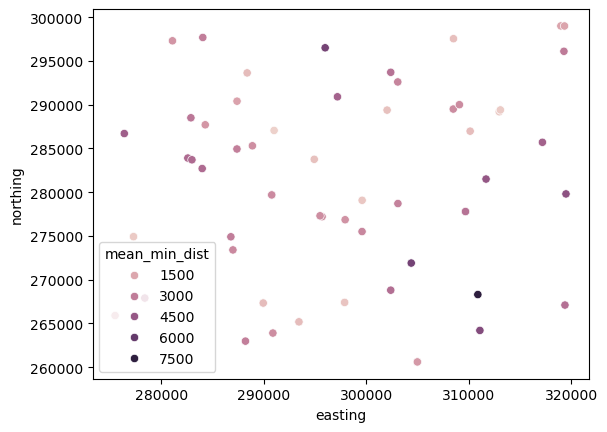

In [639]:
sns.scatterplot(x='easting', y='northing', hue='mean_min_dist', data=gauge_vs_grid_df)

Text(0.5, 1.0, 'HadUK-Grid')

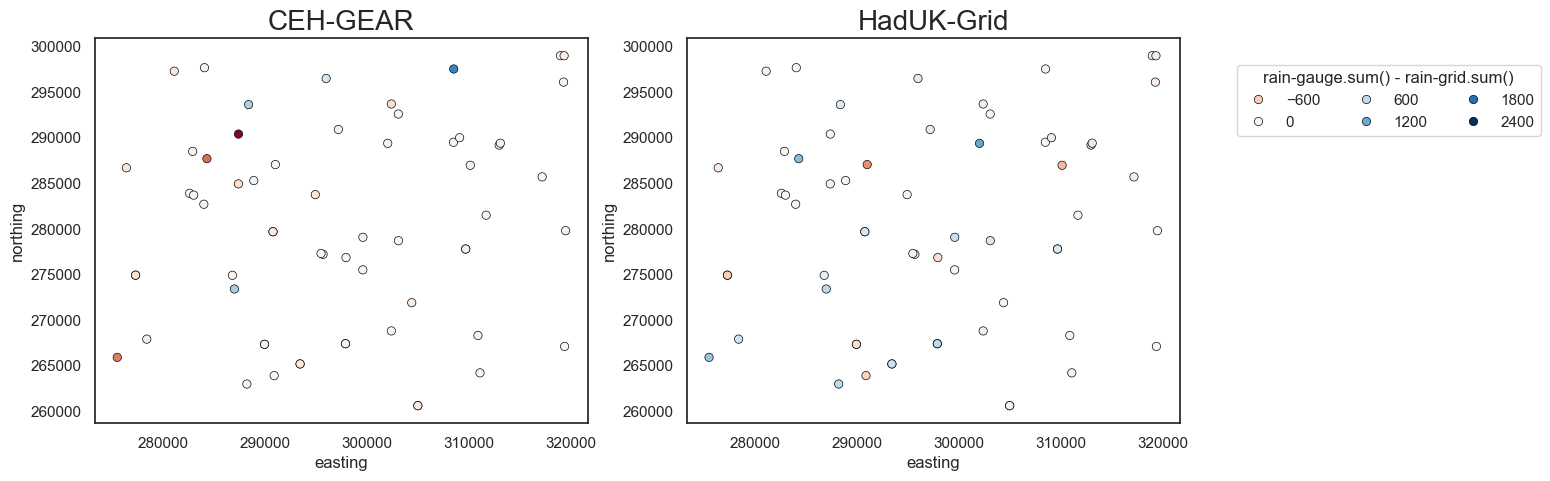

In [717]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.scatterplot(x='easting', y='northing', hue='sum_closest_ceh_diff', data=gauge_vs_grid_df, palette='RdBu', hue_norm=(-2400, 2400), edgecolor='k', legend=False, ax=axes[0])
sns.scatterplot(x='easting', y='northing', hue='sum_closest_haduk_diff', data=gauge_vs_grid_df, palette='RdBu', hue_norm=(-2400, 2400), edgecolor='k', ax=axes[1])


handles, labels  =  axes[1].get_legend_handles_labels()
axes[1].legend(handles, labels, bbox_to_anchor=(1.1, .95), ncols=3, title='rain-gauge.sum() - rain-grid.sum()')

axes[0].set_title('CEH-GEAR', size=20)
axes[1].set_title('HadUK-Grid', size=20)